# Project

Our work is greatly inspired of the following article, found in the reference of the given document:

    @article{nn-decoding,
      title={On Deep Learning-Based Channel Decoding},
      author={Tobias Gruber and
              Sebastian Cammerer and
              Jakob Hoydis and
              Stephan ten Brink}
      journal={CoRR}
      year={2017}
      url= {http://arxiv.org/abs/1701.07738}
    }

# <font color='black'>CIRI Project: Deep learning-based channel coding of short packets</font>

---

<img src="images/ipsa_logo.png" width="100" align="right">


> Year: **2024**


## <font color='black'>Contents</font>

---
 
1. [Set-Up](#Set-Up)
 * [Library Importation](#Lib)
 * [Functions Definitions](#FunctionDef)
 * [Neural Network Main Function](#FunctionNN)
 * [Maximum A Posteriori (MAP) Detector](#FunctionMAP)
 * [Variables Initialization](#InitVar)

2. [Graphics](#Graph)
 * [Bit Error Rate (BER)](#BER)
     * [$BER$ vs $\dfrac{E_b}{N_0}$: MSE and Direct Channel](#MSED)
     * [$BER$ vs $\dfrac{E_b}{N_0}$: MSE and LLR Channel](#MSELLR)
     * [$BER$ vs $\dfrac{E_b}{N_0}$: BCE and Direct Channel](#BCED)
     * [$BER$ vs $\dfrac{E_b}{N_0}$: BCE and LLR Channel](#BCELLR)
 * [Normalized Validation Error (NVE)](#NVE)
     * [$NVE$ vs $M_{ep}$: MSE vs BCE and Direct vs LLR](NVEChannelLoss)
     * [$NVE$ vs $M_{ep}$: Design Analysis](NVEChannelLoss)

This project aims to introduce the concept of channel coding in digital communication chains.  For this, we will use neural networks to carry out a reduction of the complexity in the reception chain. 
Objective: Implement a neural based decoder which approaches the MAP detector (project based on state-of-the-art paper: $On Deep Learning-Based Channel Decoding$).
Unlike the document, we will only be interested in polar coding due to a too long computation time.

## <font color='black'>Set-Up</font>

### <font color='black'>Library Importation</font>
We install and import all the library that we are going to use during this project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Lambda
from tensorflow.keras import backend as K

import itertools
import time
from scipy.special import erfc

# tells matplotlib to embed plots within the notebook
%matplotlib inline

2024-05-30 02:12:32.639417: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/bouboujr/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### <font color='black'>Functions Definitions</font>
Let's define all the functions used for our Neural Network.

In [2]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)
    return x + w

def ber(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32
    return K.mean(K.not_equal(y_true, K.round(y_pred)))

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):
    return 2*x/np.float32(sigma**2)

def errors(y_true, y_pred):
    #print(y_true)
    #print(y_pred)
    y_true = K.cast(y_true, 'float32')  # Cast y_true to int32
    #print(y_true)
    y_pred = K.cast(K.round(y_pred), 'float32')  # Ensure y_pred is rounded and cast to int32
    #print(y_pred)
    out = K.not_equal(y_true, y_pred)
    out = K.sum(K.cast(out,'float32'))
    return out

def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):  
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    idx = np.argsort(z0)
        
    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[idx] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

### <font color='black'>Neural Network Main Function</font>
Let's define the main function which contains the architecture of our Neural Network.

In [3]:
def main(k,N,nb_epoch,code,design,batch_size,LLR,optimizer,loss,train_sigma):
    
    # Define modulator
    modulator_layers = [Lambda(modulateBPSK, 
                              input_shape=(N,), output_shape=return_output_shape, name="modulator")]
    modulator = compose_model(modulator_layers)
    modulator.compile(optimizer=optimizer, loss=loss)
    
    # Define noise
    noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, 
                           input_shape=(N,), output_shape=return_output_shape, name="noise")]
    noise = compose_model(noise_layers)
    noise.compile(optimizer=optimizer, loss=loss)
    
    # Define LLR
    llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma}, 
                         input_shape=(N,), output_shape=return_output_shape, name="LLR")]
    llr = compose_model(llr_layers)
    llr.compile(optimizer=optimizer, loss=loss)
    
    # Define decoder 
    decoder_layers = [Dense(design[0], activation='relu', input_shape=(N,))]
    for i in range(1,len(design)):
        decoder_layers.append(Dense(design[i], activation='relu'))
    decoder_layers.append(Dense(k, activation='sigmoid'))
    decoder = compose_model(decoder_layers)
    decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
    
    # Define model
    if LLR:
        model_layers = modulator_layers + noise_layers + llr_layers + decoder_layers
    else:
        model_layers = modulator_layers + noise_layers + decoder_layers
    model = compose_model(model_layers)
    model.compile(optimizer=optimizer, loss=loss, metrics=[ber])
    
    
    #
    
    # Create all possible information words
    d = np.zeros((2**k,k),dtype=bool)
    for i in range(1,2**k):
        d[i]= inc_bool(d[i-1])
    
    # Create sets of all possible codewords (codebook)
    if code == 'polar':   
        
        A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
        x = np.zeros((2**k, N),dtype=bool)
        u = np.zeros((2**k, N),dtype=bool)
        u[:,A] = d
    
        for i in range(0,2**k):
            x[i] = polar_transform_iter(u[i])
    
    elif code == 'random':
        
        np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
        x = np.random.randint(0,2,size=(2**k,N), dtype=bool)
    
    #   
    model.summary()
    history = model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)
    
    # 
    
    test_batch = 1000  
    num_words = 100000      # multiple of test_batch
    
    SNR_dB_start_Eb = 0
    SNR_dB_stop_Eb = 7
    SNR_points = 8
    
    # BER calcul
    
    SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
    SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)
    
    sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
    sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))
    
    sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)
    
    nb_errors = np.zeros(len(sigmas),dtype=int)
    nb_bits = np.zeros(len(sigmas),dtype=int)
    
    for i in range(0,len(sigmas)):
    
        for ii in range(0,np.round(num_words/test_batch).astype(int)):
            
            # Source
            np.random.seed(0)
            d_test = np.random.randint(0,2,size=(test_batch,k),dtype = bool) 
            # # Assuming d_test is initially boolean
            # d_test = d_test.astype(np.float32)  # Convert boolean labels to float32 before evaluation
    
            # Encoder
            if code == 'polar':
                x_test = np.zeros((test_batch, N),dtype=bool)
                u_test = np.zeros((test_batch, N),dtype=bool)
                u_test[:,A] = d_test
    
                for iii in range(0,test_batch):
                    x_test[iii] = polar_transform_iter(u_test[iii])
    
            elif code == 'random':
                x_test = np.zeros((test_batch, N),dtype=bool)
                for iii in range(0,test_batch):
                    x_test[iii] = x[bin2int(d_test[iii])]
    
            # Modulator (BPSK)
            s_test = -2*x_test + 1
    
            # Channel (AWGN)
            y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)
    
            if LLR:
                y_test = 2*y_test/(sigmas[i]**2)
                
            # Decoder
            nb_errors[i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]
            nb_bits[i] += d_test.size
    
    return sigmas, nb_errors, nb_bits

### <font color='black'>Maximum A Posteriori (MAP) Detector</font>
Let's define the functions which will compute the theoritical BER, simulated BER with AWGN with and without polar coding.

In [4]:
Eb_N0_dB = np.arange(0, 9, 1) 
Eb_N0_lin = 10**(Eb_N0_dB / 10)  

def simulate_awgn_ber(Eb_N0):
    
    N = 1000000 # nbr bits
    bits = np.random.randint(0, 2, N) # random bits
    symbols = 2 * bits - 1 # mapping: 0 -> -1, 1 -> 1
    
    ber_simulated = np.zeros(len(Eb_N0))
    
    for i, Eb_N0_element in enumerate(Eb_N0):
        
        sigma = np.sqrt(1 / (2 * Eb_N0_element)) #variance
        
        noise = np.random.normal(0, sigma, N) #Génération de AWGN 
        
        signal_bruit = symbols + noise # signal reçu
        
        signal_bruit_det = np.where(signal_bruit >= 0, 1, 0) # threshold at 0
        
        errors = np.sum(bits != signal_bruit_det) # Mise à jour du compteur
        
        ber_simulated[i] = errors / N # Calcul BER

    return ber_simulated

def theoretical_ber(Eb_N0_lin):
    return 0.5 * erfc(np.sqrt(Eb_N0_lin))

#%% MAP coding polar

k = 8
N = 16
G = np.array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
              [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
              [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

Eb_N0_dB = np.arange(0, 8, 1)  # Eb/N0 en dB
Eb_N0_lin = 10**(Eb_N0_dB / 10)  # Eb/N0 en linéaire

# Fonction pour encoder les bits selon la matrice G
def encode_bits(bits, G):
    
    encodebits = np.dot(bits, G) % 2
    return encodebits

def decode_bits(decoded, G, k, all_possible_bits, symbols_codewords):

    # Calcul de la distance de Hamming depuis les bits décodés reçus
    distance = np.sum(((decoded-symbols_codewords)**2),axis=1)**(1/2)
        
    closest_codeword = all_possible_bits[np.argmin(distance)]
    return closest_codeword

# Fonction to simulate the BER for the given coding scheme
def simulate_coded_ber(Eb_N0_lin, k, N, G):  
     
    ber_simulated = np.zeros_like(Eb_N0_dB, dtype=float)
    
    # Génération de tous les codewords possible
    all_possible_bits = np.array(list(itertools.product([0, 1], repeat=k)))
    all_possible_codewords = encode_bits(all_possible_bits, G)
    symbols_codewords = 2 * all_possible_codewords - 1
    
    for idx in range(len(Eb_N0_lin)):
        
        sigma = np.sqrt(1 / (Eb_N0_lin[idx])) # Variance
        total_errors = 0
        compteur = 0
        
        while total_errors<700:
            
            # Generation de bits randoms
            bits = np.random.randint(0, 2, k)
            
            # Encodage des bits
            encoded_bits = encode_bits(bits, G)
            
            # BPSK modulation
            symbols = 2 * encoded_bits - 1 # mapping: 0 -> -1, 1 -> 1
            
            # AWGN channel
            noise = np.random.normal(0, sigma, N)
            received = symbols + noise
            
            # hard-decision decoding
            estimated_bits = decode_bits(received, G, k, all_possible_bits, symbols_codewords)  
            
            # Update du compteur d'erreur
            total_errors += np.sum(bits != estimated_bits)
            compteur+=1
            #print(total_errors)
            #print(idx+1, "/",8)
            
        # Calcul du BER 
        ber_simulated[idx] = total_errors / (compteur*k)
        
        #print(idx+1, "/",8)
    
    return ber_simulated

start = time.time()

ber_results = simulate_coded_ber(Eb_N0_lin, k, N, G)

end = time.time()
print('durée ',end-start)

ber_simulated = simulate_awgn_ber(Eb_N0_lin)
ber_theoretical = theoretical_ber(Eb_N0_lin)

durée  136.04111528396606


### <font color='black'>Variables Initialization</font>
Let's define the variables needed for our Neural Network

In [5]:
k = 8                       # number of information bits
N = 16                      # code length
train_SNR_Eb = 1            # training-Eb/No

nb_epoch = np.array([2**10,2**12,2**14,2**16,2**18])         # number of learning epochs
code = 'polar'              # type of code ('random' or 'polar')
design = [128, 64, 32]      # each list entry defines the number of nodes in a layer
batch_size = 256            # size of batches for calculation the gradient
LLR = False                 # 'True' enables the log-likelihood-ratio layer
optimizer = 'adam'           
loss = 'mse'                # or 'binary_crossentropy'

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))

sigmas_history_mse_direct = np.zeros((k,np.size(nb_epoch,0)))
nb_errors_history_mse_direct = np.zeros((k,np.size(nb_epoch,0)))
nb_bits_history_mse_direct = np.zeros((k,np.size(nb_epoch,0)))

sigmas_history_mse_LLR = np.zeros((k,np.size(nb_epoch,0)))
nb_errors_history_mse_LLR = np.zeros((k,np.size(nb_epoch,0)))
nb_bits_history_mse_LLR = np.zeros((k,np.size(nb_epoch,0)))

sigmas_history_bc_direct = np.zeros((k,np.size(nb_epoch,0)))
nb_errors_history_bc_direct = np.zeros((k,np.size(nb_epoch,0)))
nb_bits_history_bc_direct = np.zeros((k,np.size(nb_epoch,0)))

sigmas_history_bc_LLR = np.zeros((k,np.size(nb_epoch,0)))
nb_errors_history_bc_LLR = np.zeros((k,np.size(nb_epoch,0)))
nb_bits_history_bc_LLR = np.zeros((k,np.size(nb_epoch,0)))

NVE_history_mse_direct = np.zeros((k,np.size(nb_epoch,0)))
NVE_history_mse_LLR = np.zeros((k,np.size(nb_epoch,0)))
NVE_history_bc_direct = np.zeros((k,np.size(nb_epoch,0)))
NVE_history_bc_LLR = np.zeros((k,np.size(nb_epoch,0)))

sigmas_history_mse_direct_design_2 = np.zeros((k,np.size(nb_epoch,0)))
nb_errors_history_mse_direct_design_2 = np.zeros((k,np.size(nb_epoch,0)))
nb_bits_history_mse_direct_design_2 = np.zeros((k,np.size(nb_epoch,0)))

sigmas_history_mse_direct_design_3 = np.zeros((k,np.size(nb_epoch,0)))
nb_errors_history_mse_direct_design_3 = np.zeros((k,np.size(nb_epoch,0)))
nb_bits_history_mse_direct_design_3 = np.zeros((k,np.size(nb_epoch,0)))

sigmas_history_mse_direct_design_4 = np.zeros((k,np.size(nb_epoch,0)))
nb_errors_history_mse_direct_design_4 = np.zeros((k,np.size(nb_epoch,0)))
nb_bits_history_mse_direct_design_4 = np.zeros((k,np.size(nb_epoch,0)))

NVE_history_design_2 = np.zeros((k,np.size(nb_epoch,0)))
NVE_history_design_3 = np.zeros((k,np.size(nb_epoch,0)))
NVE_history_design_4 = np.zeros((k,np.size(nb_epoch,0)))

## <font color='black'>Graphics</font>
Now, we will compute differents Neurals Networks for differents parameters and compute some figures to compare them.

### <font color='black'>Bit Error Rate (BER)</font>
Let's compute differents BER depanding of their loss functions and channels

In [6]:
start = time.time()
for i in range(np.size(nb_epoch,0)):
    
    sigmas_history_mse_direct[:,i], nb_errors_history_mse_direct[:,i], nb_bits_history_mse_direct[:,i] = main(k,N,nb_epoch[i],code,design,batch_size,LLR,optimizer,loss,train_sigma)
    sigmas_history_mse_direct_design_2[:,i], nb_errors_history_mse_direct_design_2[:,i], nb_bits_history_mse_direct_design_2[:,i] = main(k,N,nb_epoch[i],code,[256,128,64],batch_size,LLR,optimizer,loss,train_sigma)
    sigmas_history_mse_direct_design_3[:,i], nb_errors_history_mse_direct_design_3[:,i], nb_bits_history_mse_direct_design_3[:,i] = main(k,N,nb_epoch[i],code,[512,256,128],batch_size,LLR,optimizer,loss,train_sigma)
    sigmas_history_mse_direct_design_4[:,i], nb_errors_history_mse_direct_design_4[:,i], nb_bits_history_mse_direct_design_4[:,i] = main(k,N,nb_epoch[i],code,[1024,512,256],batch_size,LLR,optimizer,loss,train_sigma)

    sigmas_history_mse_LLR[:,i], nb_errors_history_mse_LLR[:,i], nb_bits_history_mse_LLR[:,i] = main(k,N,nb_epoch[i],code,design,batch_size,True,optimizer,loss,train_sigma)
    
    sigmas_history_bc_direct[:,i], nb_errors_history_bc_direct[:,i], nb_bits_history_bc_direct[:,i] = main(k,N,nb_epoch[i],code,design,batch_size,LLR,optimizer,'binary_crossentropy',train_sigma)

    sigmas_history_bc_LLR[:,i], nb_errors_history_bc_LLR[:,i], nb_bits_history_bc_LLR[:,i] = main(k,N,nb_epoch[i],code,design,batch_size,True,optimizer,'binary_crossentropy',train_sigma)
    
end = time.time()
print('durée ',end-start)

/Users/bouboujr/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/bouboujr/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,024 (179.78 KB)

 Trainable params: 46,024 (179.78 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,960 (679.53 KB)

 Trainable params: 173,960 (679.53 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,592 (2.58 MB)

 Trainable params: 675,592 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LLR (Lambda)                    │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LLR (Lambda)                    │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,024 (179.78 KB)

 Trainable params: 46,024 (179.78 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 512)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,960 (679.53 KB)

 Trainable params: 173,960 (679.53 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1024)           │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,592 (2.58 MB)

 Trainable params: 675,592 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LLR (Lambda)                    │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LLR (Lambda)                    │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,024 (179.78 KB)

 Trainable params: 46,024 (179.78 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 512)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,960 (679.53 KB)

 Trainable params: 173,960 (679.53 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1024)           │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,592 (2.58 MB)

 Trainable params: 675,592 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LLR (Lambda)                    │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LLR (Lambda)                    │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,024 (179.78 KB)

 Trainable params: 46,024 (179.78 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 512)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,960 (679.53 KB)

 Trainable params: 173,960 (679.53 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 1024)           │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,592 (2.58 MB)

 Trainable params: 675,592 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LLR (Lambda)                    │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_134"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LLR (Lambda)                    │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_144"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,024 (179.78 KB)

 Trainable params: 46,024 (179.78 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_154"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 512)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,960 (679.53 KB)

 Trainable params: 173,960 (679.53 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 1024)           │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,592 (2.58 MB)

 Trainable params: 675,592 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_164"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LLR (Lambda)                    │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_174"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ modulator (Lambda)              │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ noise (Lambda)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LLR (Lambda)                    │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

durée  54052.643052101135


#### <font color='blue'>$BER$ vs $\dfrac{E_b}{N_0}$: MSE and Direct Channel</font>

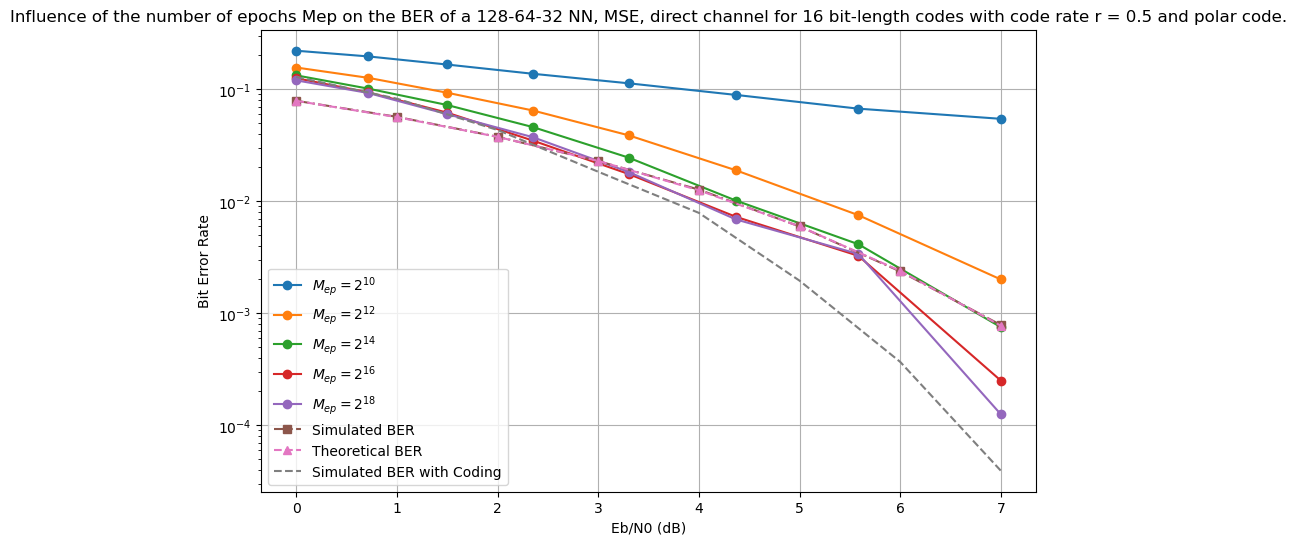

In [17]:
plt.figure(figsize=(10, 6))

for i in range(np.size(nb_epoch,0)):
    plt.plot(10*np.log10(1/(2*sigmas_history_mse_direct[:,i]**2)) - 10*np.log10(k/N), nb_errors_history_mse_direct[:,i]/nb_bits_history_mse_direct[:,i],'o-', label=r'$M_{{ep}} = 2^{{{}}}$'.format(int(np.log2(nb_epoch[i]))))
    
plt.plot(Eb_N0_dB, ber_simulated, 's-.', label='Simulated BER')
plt.plot(Eb_N0_dB, ber_theoretical, '^--', label='Theoretical BER')
plt.plot(Eb_N0_dB, ber_results, '--', label='Simulated BER with Coding')
plt.yscale('log')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Bit Error Rate')
plt.title('Influence of the number of epochs Mep on the BER of a 128-64-32 NN, MSE, direct channel for 16 bit-length codes with code rate r = 0.5 and polar code.')
plt.legend()
plt.grid(True)
plt.show()

#### <font color='blue'>$BER$ vs $\dfrac{E_b}{N_0}$: MSE and LLR Channel</font>

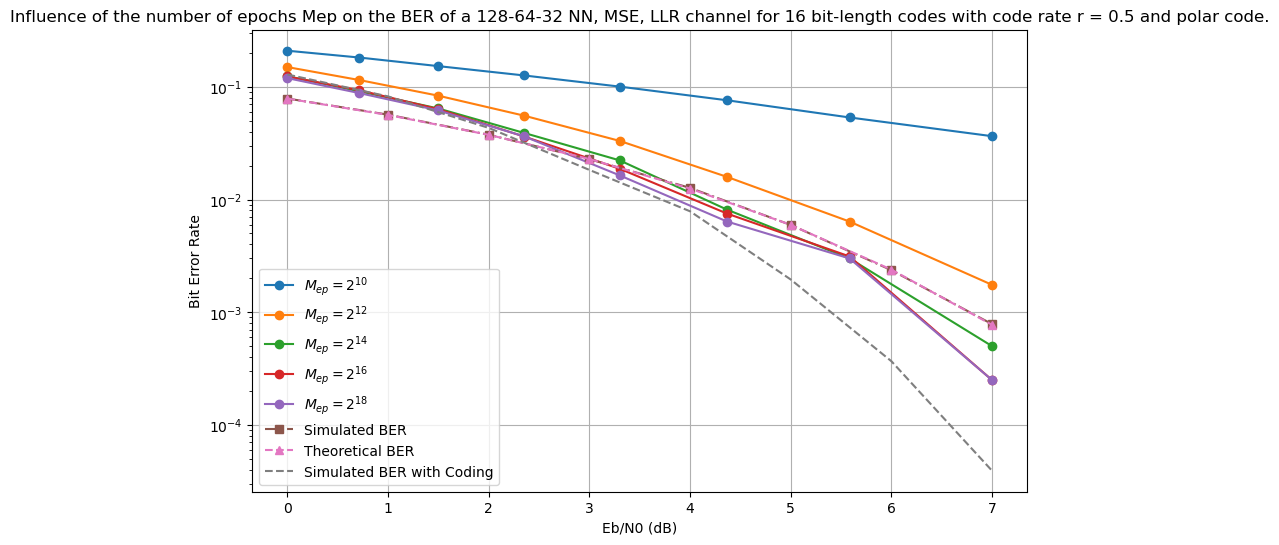

In [18]:
plt.figure(figsize=(10, 6))

for i in range(np.size(nb_epoch,0)):
    plt.plot(10*np.log10(1/(2*sigmas_history_mse_LLR[:,i]**2)) - 10*np.log10(k/N), nb_errors_history_mse_LLR[:,i]/nb_bits_history_mse_LLR[:,i],'o-', label=r'$M_{{ep}} = 2^{{{}}}$'.format(int(np.log2(nb_epoch[i]))))
    
plt.plot(Eb_N0_dB, ber_simulated, 's-.', label='Simulated BER')
plt.plot(Eb_N0_dB, ber_theoretical, '^--', label='Theoretical BER')
plt.plot(Eb_N0_dB, ber_results, '--', label='Simulated BER with Coding')
plt.yscale('log')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Bit Error Rate')
plt.title('Influence of the number of epochs Mep on the BER of a 128-64-32 NN, MSE, LLR channel for 16 bit-length codes with code rate r = 0.5 and polar code.')
plt.legend()
plt.grid(True)
plt.show()

#### <font color='blue'>$BER$ vs $\dfrac{E_b}{N_0}$: BCE and Direct Channel</font>

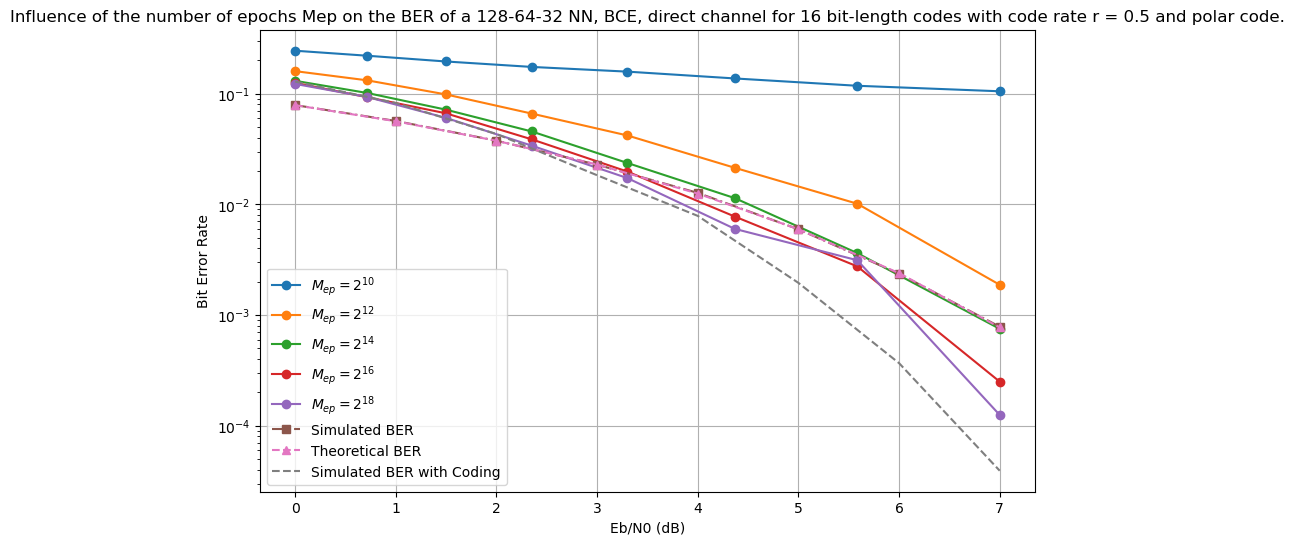

In [19]:
plt.figure(figsize=(10, 6))

for i in range(np.size(nb_epoch,0)):
    plt.plot(10*np.log10(1/(2*sigmas_history_bc_direct[:,i]**2)) - 10*np.log10(k/N), nb_errors_history_bc_direct[:,i]/nb_bits_history_bc_direct[:,i],'o-', label=r'$M_{{ep}} = 2^{{{}}}$'.format(int(np.log2(nb_epoch[i]))))
    
plt.plot(Eb_N0_dB, ber_simulated, 's-.', label='Simulated BER')
plt.plot(Eb_N0_dB, ber_theoretical, '^--', label='Theoretical BER')
plt.plot(Eb_N0_dB, ber_results, '--', label='Simulated BER with Coding')
plt.yscale('log')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Bit Error Rate')
plt.title('Influence of the number of epochs Mep on the BER of a 128-64-32 NN, BCE, direct channel for 16 bit-length codes with code rate r = 0.5 and polar code.')
plt.legend()
plt.grid(True)
plt.show()

#### <font color='blue'>$BER$ vs $\dfrac{E_b}{N_0}$: BCE and LLR Channel</font>

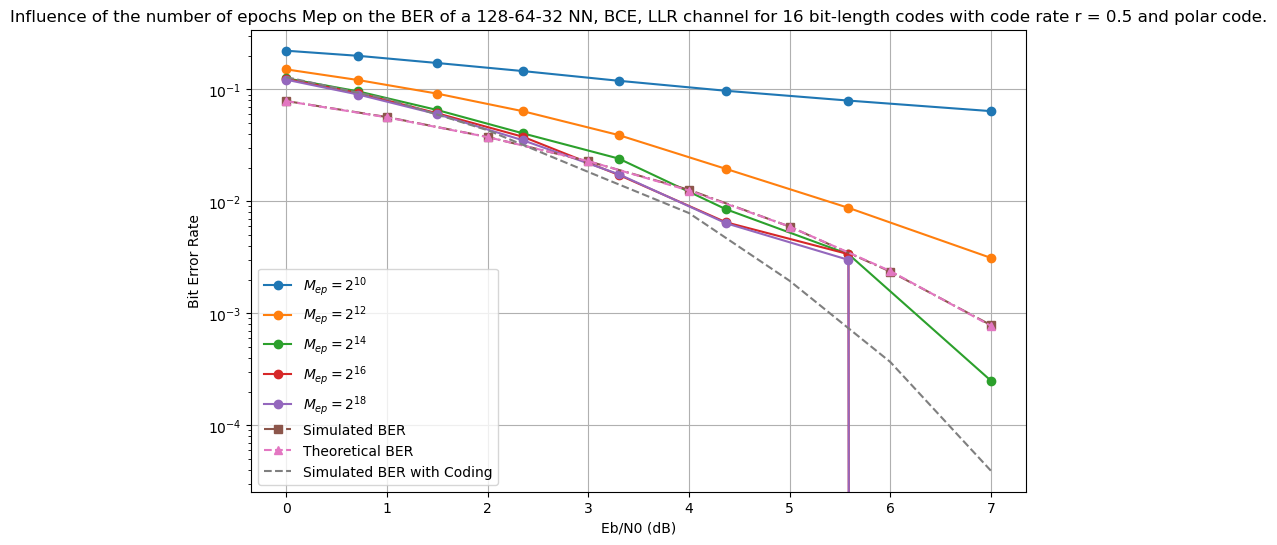

In [20]:
plt.figure(figsize=(10, 6))

for i in range(np.size(nb_epoch,0)):
    plt.plot(10*np.log10(1/(2*sigmas_history_bc_LLR[:,i]**2)) - 10*np.log10(k/N), nb_errors_history_bc_LLR[:,i]/nb_bits_history_bc_LLR[:,i],'o-', label=r'$M_{{ep}} = 2^{{{}}}$'.format(int(np.log2(nb_epoch[i]))))
    
plt.plot(Eb_N0_dB, ber_simulated, 's-.', label='Simulated BER')
plt.plot(Eb_N0_dB, ber_theoretical, '^--', label='Theoretical BER')
plt.plot(Eb_N0_dB, ber_results, '--', label='Simulated BER with Coding')
plt.yscale('log')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Bit Error Rate')
plt.title('Influence of the number of epochs Mep on the BER of a 128-64-32 NN, BCE, LLR channel for 16 bit-length codes with code rate r = 0.5 and polar code.')
plt.legend()
plt.grid(True)
plt.show()

### <font color='black'>Normalized Validation Error (NVE)</font>
Let's compute differents NVE depanding of their loss functions, channels and Neurals Networks designs

In [21]:
NVE_history_mse_direct = np.zeros((k,np.size(nb_epoch,0)))
NVE_history_mse_LLR = np.zeros((k,np.size(nb_epoch,0)))
NVE_history_bc_direct = np.zeros((k,np.size(nb_epoch,0)))
NVE_history_bc_LLR = np.zeros((k,np.size(nb_epoch,0)))

NVE_history_design_2 = np.zeros((k,np.size(nb_epoch,0)))
NVE_history_design_3 = np.zeros((k,np.size(nb_epoch,0)))
NVE_history_design_4 = np.zeros((k,np.size(nb_epoch,0)))

for i in range(np.size(nb_epoch,0)):
    
    NVE_history_mse_direct[:,i] = (nb_errors_history_mse_direct[:,i]/nb_bits_history_mse_direct[:,i])/ber_results
    NVE_history_design_2[:,i] = (nb_errors_history_mse_direct_design_2[:,i]/nb_bits_history_mse_direct_design_2[:,i])/ber_results
    NVE_history_design_3[:,i] = (nb_errors_history_mse_direct_design_3[:,i]/nb_bits_history_mse_direct_design_3[:,i])/ber_results
    NVE_history_design_4[:,i] = (nb_errors_history_mse_direct_design_4[:,i]/nb_bits_history_mse_direct_design_4[:,i])/ber_results

    NVE_history_mse_LLR[:,i] = (nb_errors_history_mse_LLR[:,i]/nb_bits_history_mse_LLR[:,i])/ber_results
    
    NVE_history_bc_direct[:,i] = (nb_errors_history_bc_direct[:,i]/nb_bits_history_bc_direct[:,i])/ber_results
    
    NVE_history_bc_LLR[:,i] = (nb_errors_history_bc_LLR[:,i]/nb_bits_history_bc_LLR[:,i])/ber_results

NVE_history_mse_direct = np.sum(NVE_history_mse_direct,axis=0)

NVE_history_design_2 = np.sum(NVE_history_design_2,axis = 0)
NVE_history_design_3 = np.sum(NVE_history_design_3,axis = 0)
NVE_history_design_4 = np.sum(NVE_history_design_4,axis = 0)

NVE_history_mse_LLR = np.sum(NVE_history_mse_LLR, axis = 0)
NVE_history_bc_direct = np.sum(NVE_history_bc_direct, axis = 0)
NVE_history_bc_LLR = np.sum(NVE_history_bc_LLR, axis = 0)

#### <font color='blue'>$NVE$ vs $M_{ep}$: MSE vs BCE and Direct vs LLR</font>

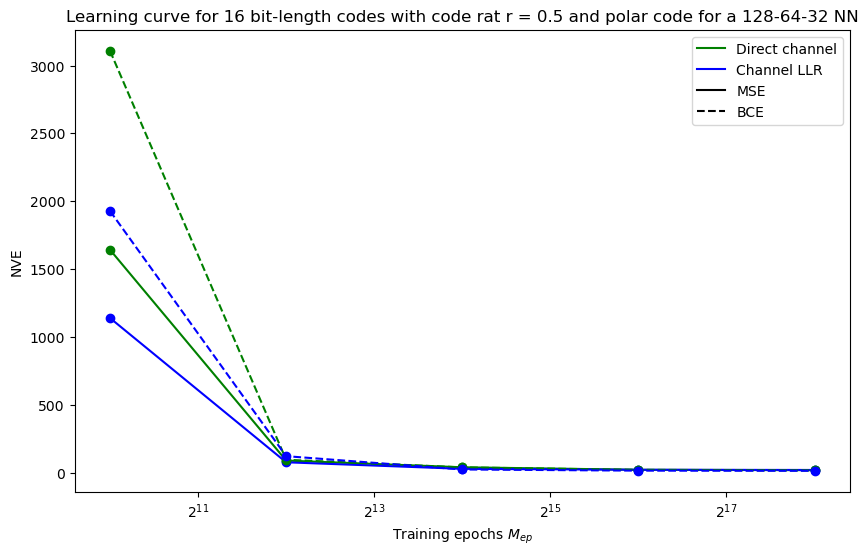

In [22]:
plt.figure(figsize=(10, 6))

legend_lines = [
    Line2D([0], [0], color='g', label='Direct channel'),
    Line2D([0], [0], color='b', label='Channel LLR'),
    Line2D([0], [0], color='k', linestyle='-', label='MSE'),
    Line2D([0], [0], color='k', linestyle='--', label='BCE')
]

plt.plot(nb_epoch, NVE_history_mse_direct, 'go-')
plt.plot(nb_epoch, NVE_history_mse_LLR, 'bo-')
plt.plot(nb_epoch, NVE_history_bc_direct, 'go--')
plt.plot(nb_epoch, NVE_history_bc_LLR, 'bo--')
plt.xscale('log', base = 2)
plt.xlabel(r'Training epochs $M_{{ep}}$')
plt.ylabel('NVE')
plt.title('Learning curve for 16 bit-length codes with code rat r = 0.5 and polar code for a 128-64-32 NN')
plt.legend(handles=legend_lines, loc='best')

#### <font color='blue'>$NVE$ vs $M_{ep}$: Design Analysis</font>

For this analysis, we would take different Neurals Networks designs but all of them used MSE as the loss function and Direct channel.

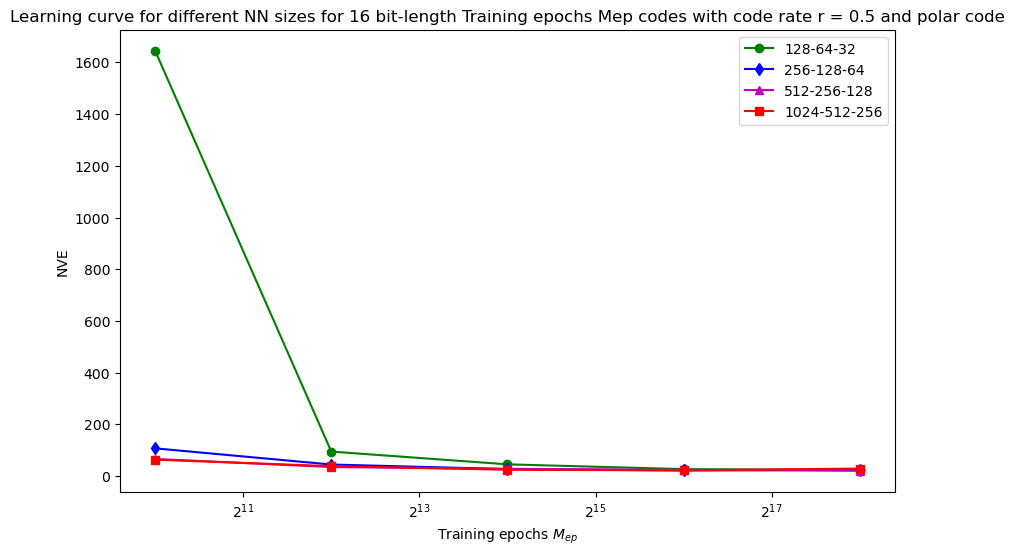

In [23]:
plt.figure(figsize=(10, 6))

legend_lines = [
    Line2D([0], [0], color='g', linestyle='-', marker='o', label='128-64-32'),
    Line2D([0], [0], color='b', linestyle='-', marker='d', label='256-128-64'),
    Line2D([0], [0], color='m', linestyle='-', marker='^', label='512-256-128'),
    Line2D([0], [0], color='r', linestyle='-', marker='s', label='1024-512-256'),
]

plt.plot(nb_epoch, NVE_history_mse_direct, 'go-')
plt.plot(nb_epoch, NVE_history_design_2, 'bd-')
plt.plot(nb_epoch, NVE_history_design_3, 'm^-')
plt.plot(nb_epoch, NVE_history_design_4, 'rs-')
plt.xscale('log', base = 2)
plt.xlabel(r'Training epochs $M_{{ep}}$')
plt.ylabel('NVE')
plt.title('Learning curve for different NN sizes for 16 bit-length Training epochs Mep codes with code rate r = 0.5 and polar code')
plt.legend(handles=legend_lines, loc='best')